In [1]:
import seaborn as sns
import pandas as pd
import json

In [2]:
import os
import glob

In [3]:
def load_metrics_file(file_name):
    with open(file_name, 'r') as f:
        return json.load(f)

In [4]:
def load_metrics(folder):
    server = load_metrics_file(folder + '/server.json')
    clients = [load_metrics_file(f.replace('\\', '/')) for f in glob.glob(folder + '/*.json') if 'server' not in f]
    return server, clients

In [5]:
def join_clients_dataset(clients):
    result = {}
    for c in clients:
        if len(c['traffic_in']) == 0 or len(c['traffic_out']) == 0:
            continue
        for k, v in c.items():
            if k in ['latencies', 'traffic_in', 'traffic_out']:
                continue
            if k in result:
                result[k].append(v)
            else:
                result[k] = [v]
    return pd.DataFrame(result)

In [6]:
def append_server_data(clients, server):
    clients['class'] = 'client'
    server['class'] = 'server'
    row = [server[col] for col in clients]
    clients.loc[len(clients)] = row
    return clients

In [17]:
def form_pandas(clients, server):
    df = append_server_data(join_clients_dataset(clients), server)
    df[['avg_traffic_in', 'avg_traffic_out', 'max_traffic_in', 'max_traffic_out']] /= 1000
    df['traffic_in_total_kb'] = df['traffic_in_total'] / 1000
    df['traffic_out_total_kb'] = df['traffic_out_total'] / 1000
    return df

In [8]:
def get_data(folder):
    server, clients = load_metrics(folder)
    return form_pandas(clients, server)

In [86]:
def extract_series(source, column):
    series = pd.DataFrame(source[column], columns=['time', column])
    return series
#     return series.set_index('time')

In [10]:
# server, clients = load_metrics('../metrics_cs')
# data = form_pandas(clients, server)

In [134]:
def plot_traffic(ref_dataset, dataset, column):
    def get_dataset(ds, name):
        server, _ = load_metrics(ds)
        series = extract_series(server, column)
        series['dataset'] = name
        series = series.iloc[1000:3000]
        return series
    series = get_dataset('../metrics_gg_10_10', 'GG')
    ref_series = get_dataset('../metrics_cs', 'C/S')
    r_series = get_dataset('../metrics_gg_almr_10_10', 'GG Resp')
    series['time'] -= series['time'].iloc[0]
    ref_series['time'] -= ref_series['time'].iloc[0]
    r_series['time'] -= r_series['time'].iloc[0]
    series = pd.concat([series, ref_series], ignore_index=True)
    
    sns.set(rc={'figure.figsize':(15,6)})
    sns.lineplot(data=series[series['time'] < 10000], palette="tab10", x='time', y=column, hue='dataset', linewidth=2.5)

In [135]:
sns.set_theme(style="whitegrid")

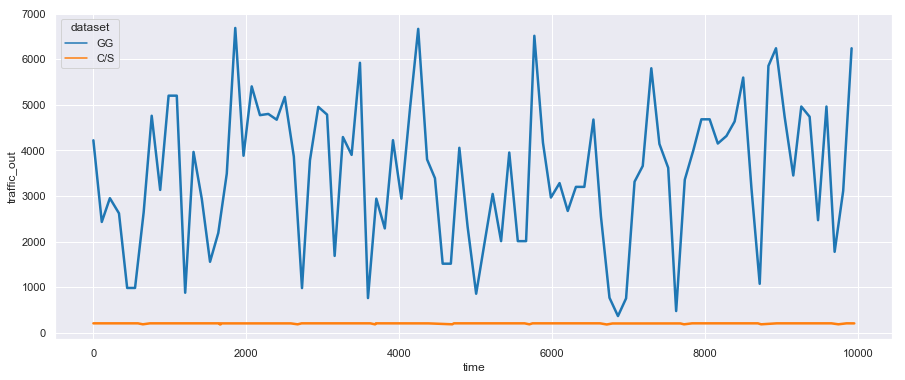

In [136]:
plot_traffic('../metrics_cs', '../metrics_gg_10_10', 'traffic_out')

In [13]:
import matplotlib.pyplot as plt 

In [14]:
# sns.set(rc={'figure.figsize':(15,6)})
# sns.lineplot(data=series.iloc[1000:3000], palette="tab10", linewidth=2.5)

In [15]:
def plot_data(data):
    sns.set(rc={'figure.figsize':(15,10)})

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.1, wspace=0.4)
    
    def plot(y, label, palette, idx):
        ax = fig.add_subplot(2, 5, idx)
        g = sns.barplot(
            data=data,
            x="class", y=y,
            ci="sd", palette=palette, alpha=.6,
            ax=ax
        )
        g.set(xlabel='', ylabel=label)
    
    plot('max_latency', 'Max Latency (ms)', 'tab10', 1)
    plot('avg_traffic_in', 'Avg Traffic In (KB)', 'dark', 2)
    plot('max_traffic_in', 'Max Traffic In (KB)', 'dark', 3)
    plot('traffic_in_rate', 'Traffic In Rate (KB/s)', 'dark', 4)
    plot('traffic_in_total_kb', 'Traffic In Total (KB)', 'dark', 5)
    
    plot('avg_latency', 'Avg Latency (ms)', 'tab10', 6)
    plot('avg_traffic_out', 'Avg Traffic out (KB)', 'Set2', 7)
    plot('max_traffic_out', 'Max Traffic out (KB)', 'Set2', 8)
    plot('traffic_out_rate', 'Traffic out Rate (KB/s)', 'Set2', 9)
    plot('traffic_out_total_kb', 'Traffic out Total (KB)', 'Set2', 10)
    
    plt.show()

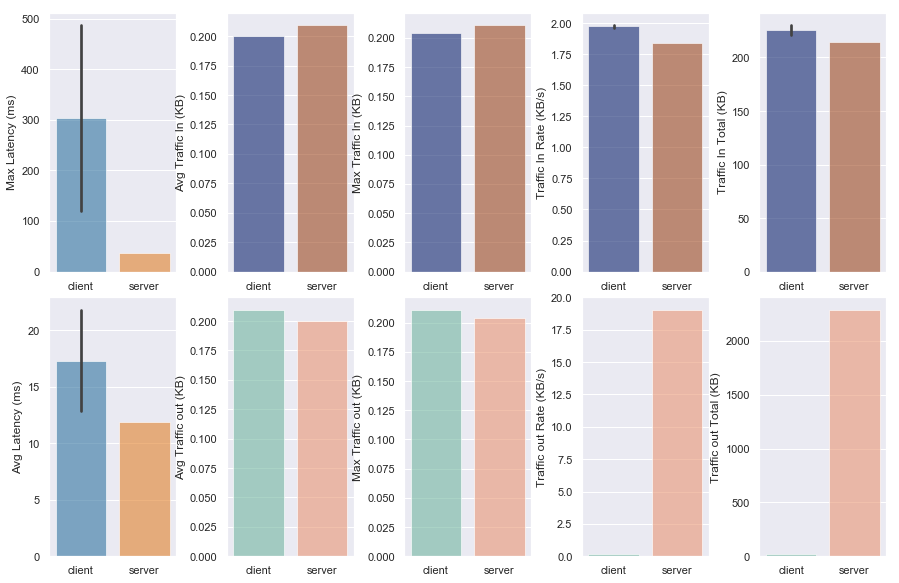

In [18]:
plot_data(get_data('../metrics_cs'))

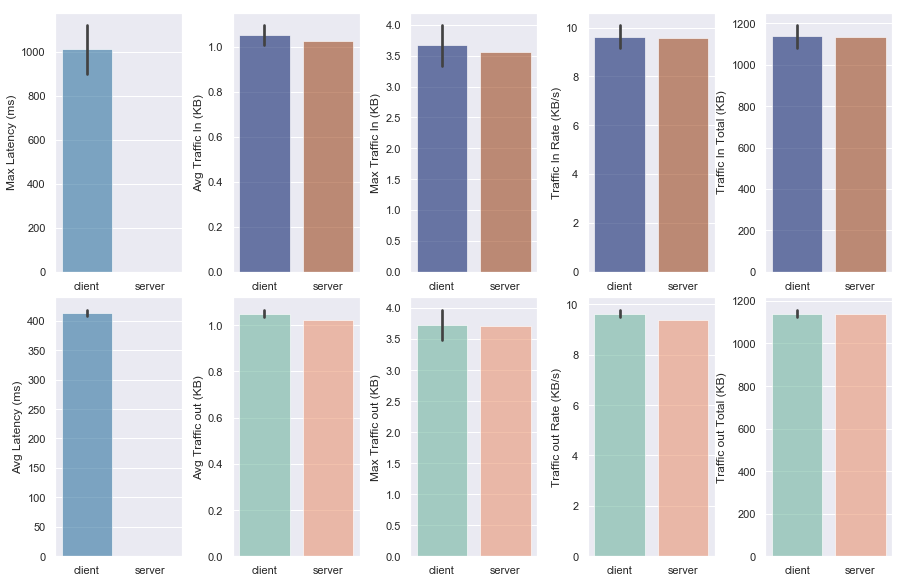

In [50]:
plot_data(get_data('../metrics_gg_10_5'))

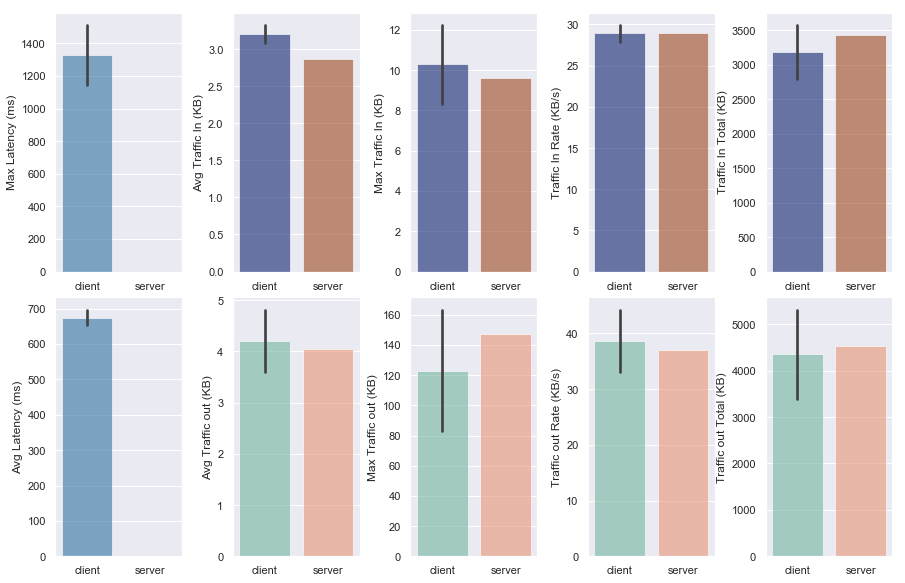

In [19]:
plot_data(get_data('../metrics_gg_10_10'))

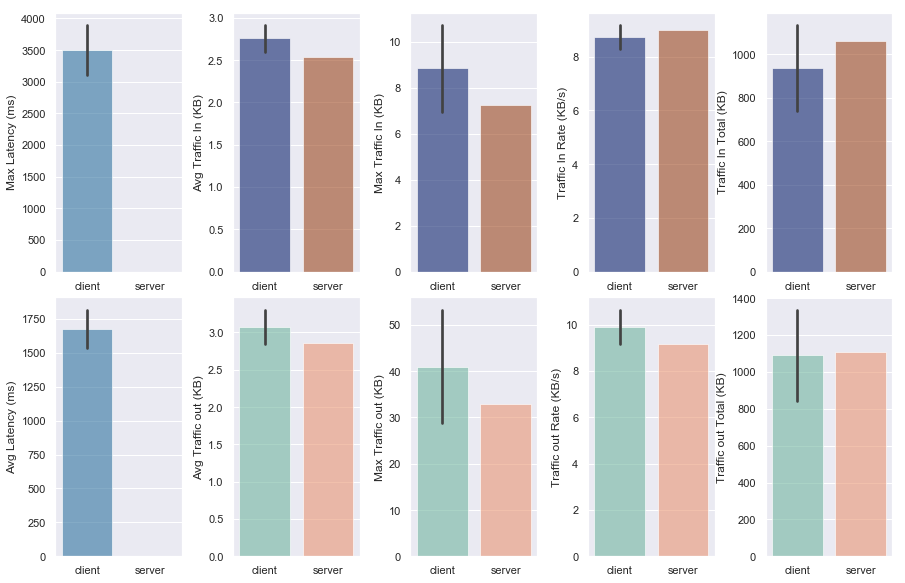

In [20]:
plot_data(get_data('../metrics_gg_3_10'))

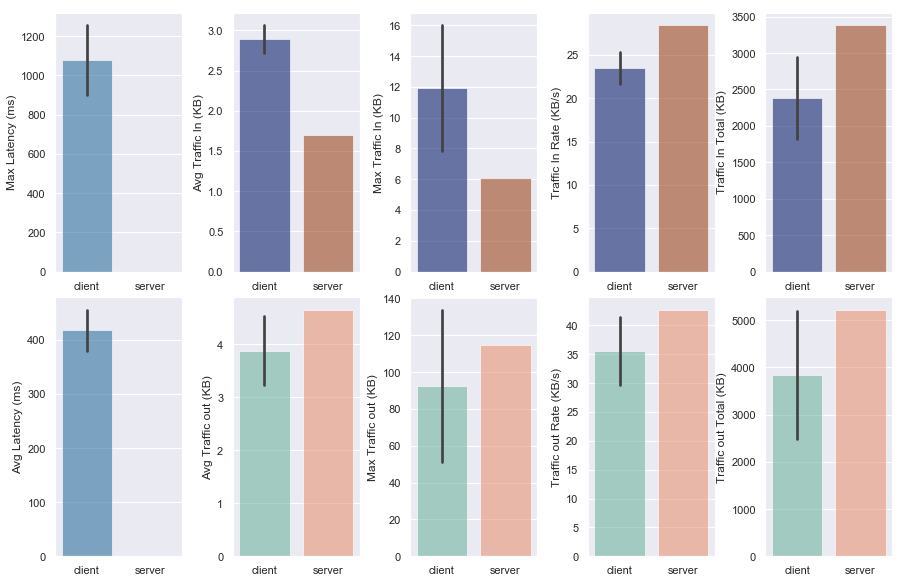

In [24]:
plot_data(get_data('../metrics_gg_ll_10_10'))

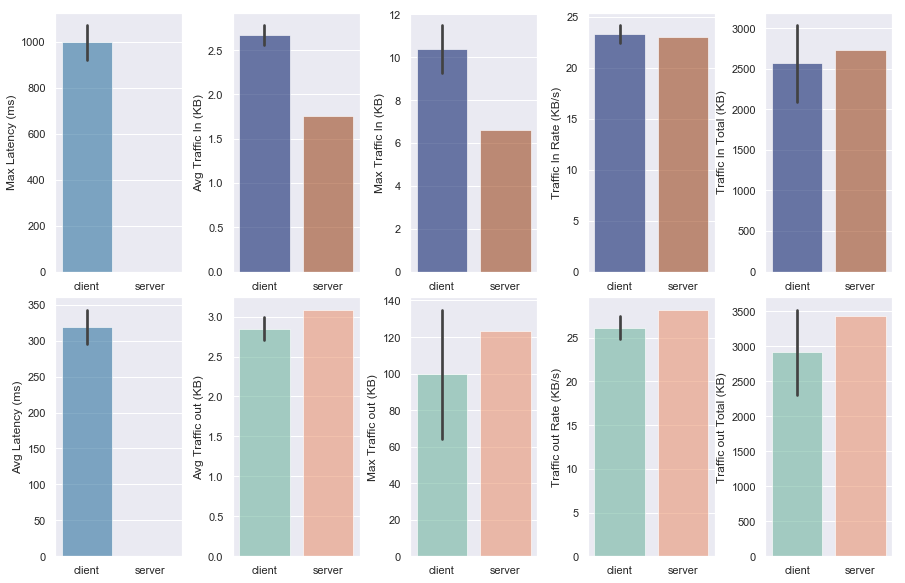

In [131]:
plot_data(get_data('../metrics_gg_almr_10_10'))

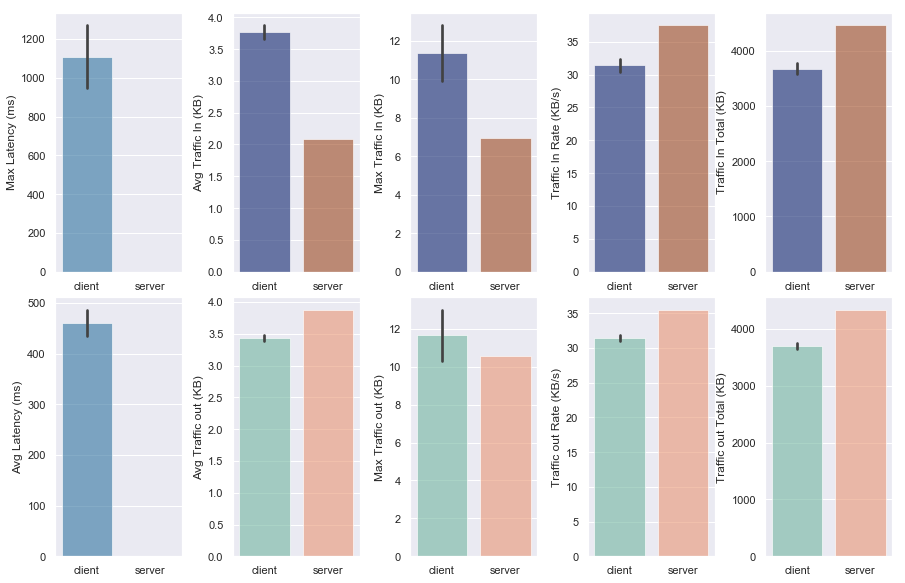

In [27]:
plot_data(get_data('../metrics_gg_alm_10_10'))

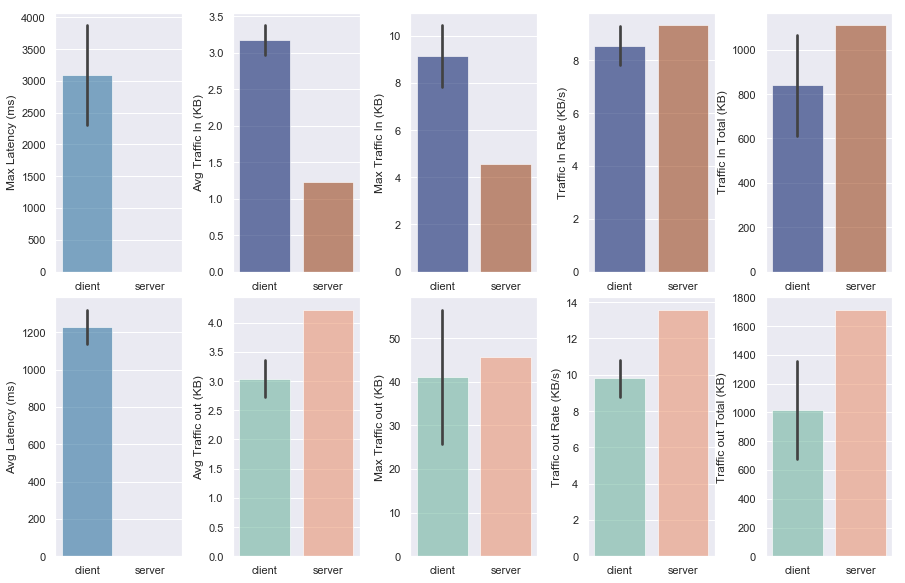

In [28]:
plot_data(get_data('../metrics_gg_alm_3_10'))

In [151]:
def plot_side_by_side(subset):
    df1 = get_data('../metrics_cs'); df1['dataset'] = 'C/S'
    df2 = get_data('../metrics_gg_10_10'); df2['dataset'] = 'GG 10'
    df3 = get_data('../metrics_gg_ll_10_10'); df3['dataset'] = 'GGLL 10'
    df4 = get_data('../metrics_gg_alm_10_10'); df4['dataset'] = 'GGLE 10'
    df5 = get_data('../metrics_gg_almr_10_10'); df5['dataset'] = 'GGR 10'
    df6 = get_data('../metrics_gg_3_10'); df6['dataset'] = 'GG 3'
    df7 = get_data('../metrics_gg_almr_3_10'); df7['dataset'] = 'GGLE 3'
    
    data = pd.concat([df1, df2, df3, df4, df5, df6, df7])
    
    sns.set(rc={'figure.figsize':(15,10)})

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.1, wspace=0.2)
    
    def plot(y, label, palette, idx):
        ax = fig.add_subplot(2, 2, idx)
        g = sns.barplot(
            data=data[data['class'] == subset],
            x="dataset", y=y,
            ci="sd", palette=palette, alpha=.6,
            ax=ax
        )
        g.set(xlabel='', ylabel=label)
    
    plot('max_latency', 'Max Latency (ms)', 'tab10', 1)
    plot('avg_latency', 'Avg Latency (ms)', 'tab10', 2)
    
    plot('traffic_in_total_kb', 'Traffic In Total (KB)', 'Set2', 3)
    plot('traffic_out_total_kb', 'Traffic out Total (KB)', 'Set2', 4)
    
    plt.show()

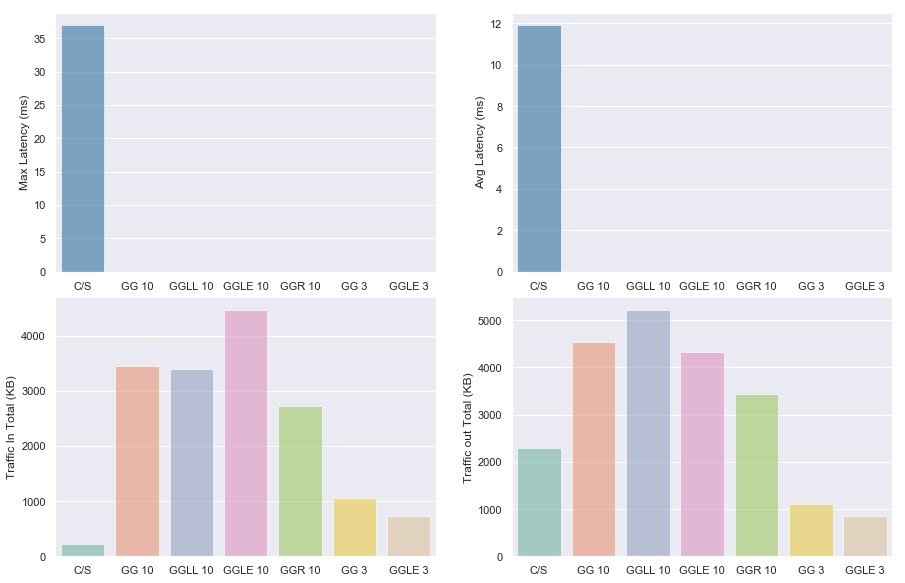

In [152]:
plot_side_by_side('server')

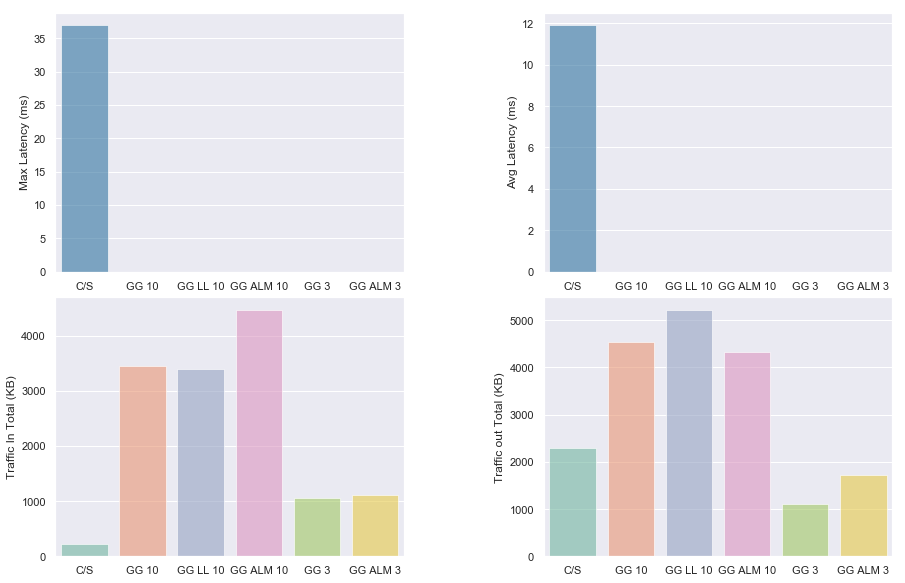

In [48]:
plot_side_by_side('server')

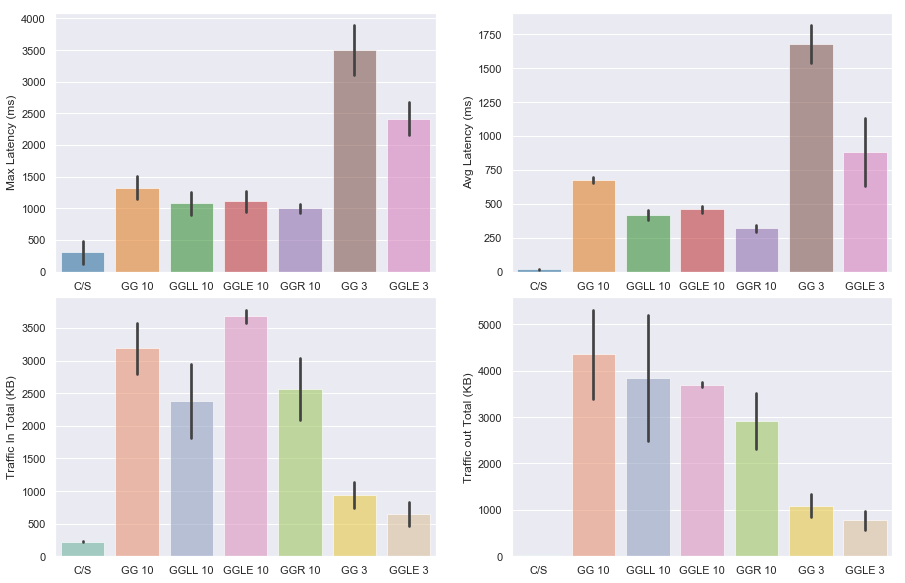

In [153]:
plot_side_by_side('client')

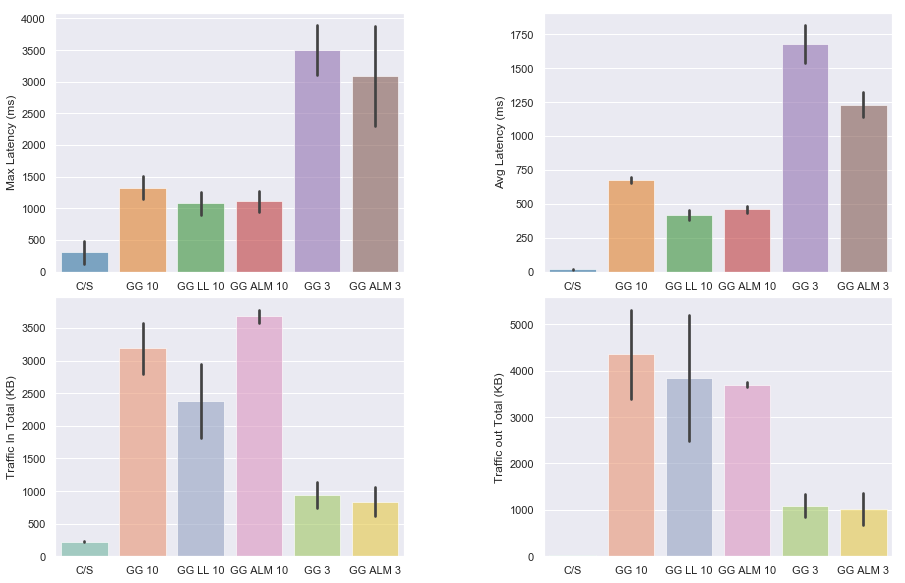

In [49]:
plot_side_by_side('client')

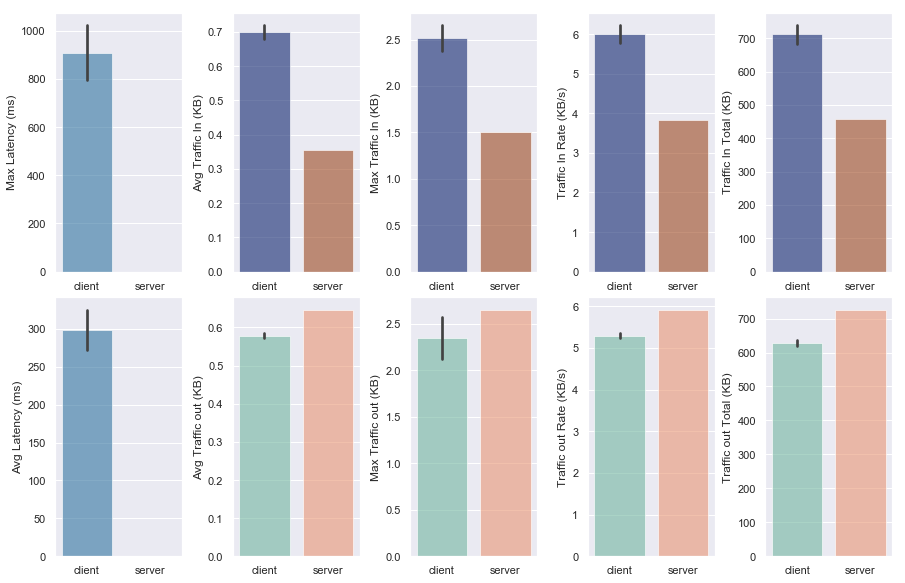

In [53]:
plot_data(get_data('../metrics_gg_alm_10_3'))

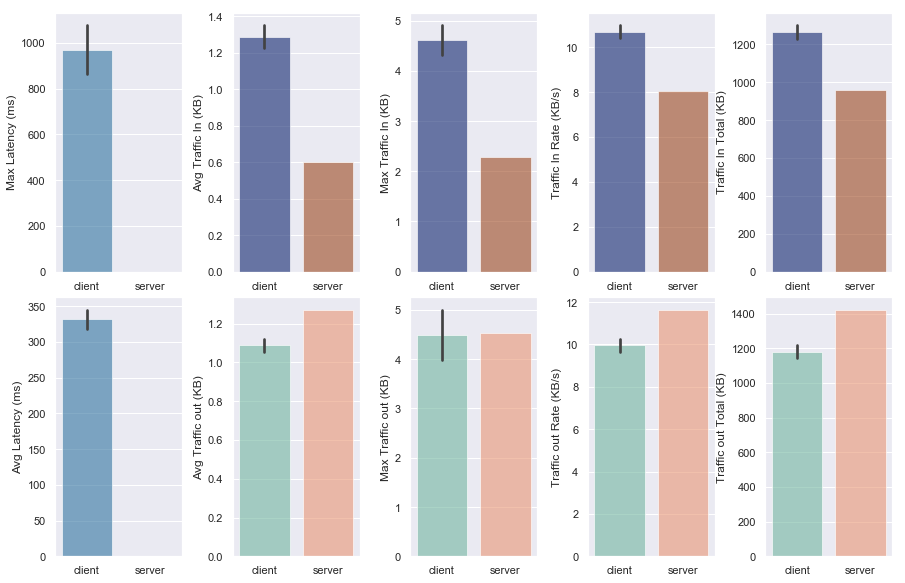

In [51]:
plot_data(get_data('../metrics_gg_alm_10_5'))

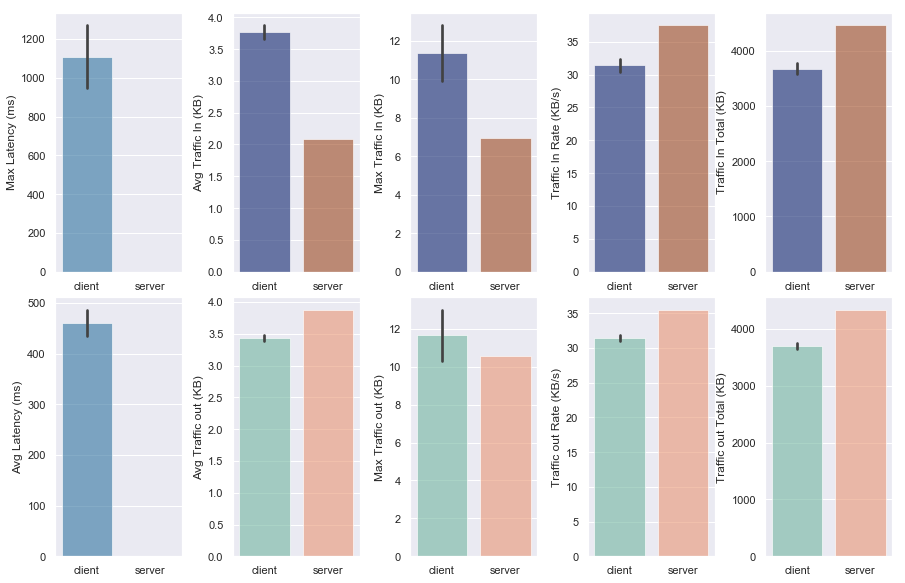

In [52]:
plot_data(get_data('../metrics_gg_alm_10_10'))

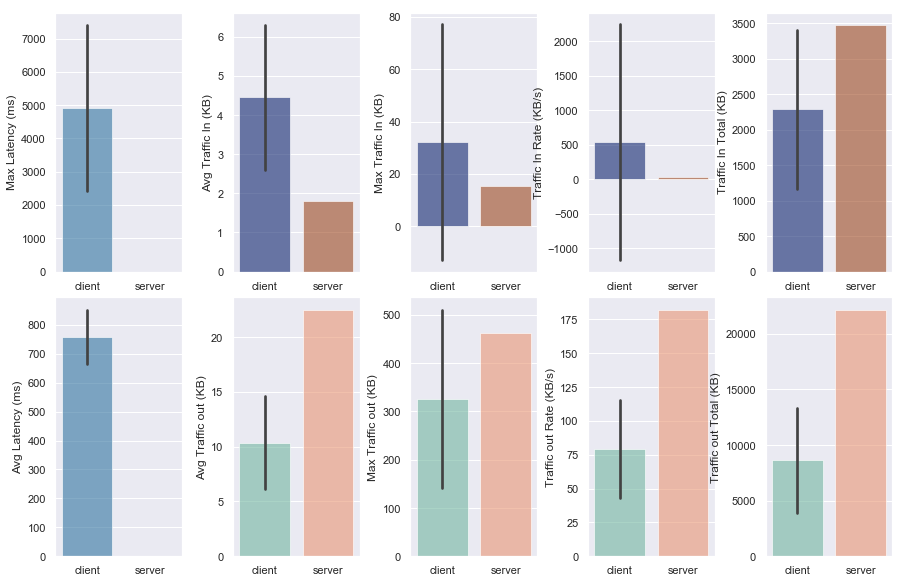

In [55]:
plot_data(get_data('../metrics_gg_alm_10_12'))

In [56]:
get_data('../metrics_gg_alm_10_12')

,avg_latency,avg_traffic_in,avg_traffic_out,max_latency,max_traffic_in,max_traffic_out,traffic_in_rate,traffic_out_rate,traffic_in_total,traffic_out_total,class,traffic_in_total_kb,traffic_out_total_kb
0,685.238636,3.189593,11.021817,4276.0,9.163,216.367,21.928483,85.735507,2583570,10129050,client,2583.570,10129.050
1,NaN,9.722387,4.409646,NaN,171.242,75.180,14.862370,14.310229,904182,873110,client,904.182,873.110
2,775.272727,3.844849,12.873494,4835.0,21.266,480.197,25.830894,98.830713,3014362,11624765,client,3014.362,11624.765
3,959.538462,3.117222,9.132626,2386.0,11.305,112.766,16.937119,65.515860,533045,2100504,client,533.045,2100.504
4,707.759494,4.817607,12.032990,6336.0,21.831,483.997,32.409148,90.203867,3767369,10528866,client,3767.369,10528.866
5,712.357143,3.215446,11.307954,3429.0,11.195,503.965,22.005719,92.472596,2601296,10934792,client,2601.296,10934.792
6,686.192771,3.134474,10.501777,3067.0,10.694,533.545,21.932193,85.878284,2554596,10071204,client,2554.596,10071.204
7,693.235955,3.273926,11.989435,3522.0,11.153,535.381,21.196644,97.321672,2468540,11377974,client,2468.540,11377.974
8,681.185185,3.429030,11.413871,3103.0,11.036,335.869,23.397403,92.874529,2510050,10386623,client,2510.050,10386.623
9,909.333333,5.157288,11.432449,11127.0,67.183,237.948,29.420709,82.418398,3274878,9260284,client,3274.878,9260.284


In [68]:
def plot_scaling(subset):
    df2 = get_data('../metrics_gg_alm_10_3'); df2['dataset'] = '3'
    df3 = get_data('../metrics_gg_alm_10_5'); df3['dataset'] = '5'
    df4 = get_data('../metrics_gg_alm_10_10'); df4['dataset'] = '10'
    df5 = get_data('../metrics_gg_alm_10_12'); df5['dataset'] = '12(+3)'
    
    data = pd.concat([df2, df3, df4, df5])
    
    sns.set(rc={'figure.figsize':(15,5)})

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.1, wspace=0.4)
    
    def plot(y, label, palette, idx):
        ax = fig.add_subplot(1, 4, idx)
        g = sns.barplot(
            data=data[data['class'] == subset],
            x="dataset", y=y,
            ci="sd", palette=palette, alpha=.6,
            ax=ax
        )
        g.set(xlabel='', ylabel=label)
    
    plot('max_latency', 'Max Latency (ms)', 'tab10', 1)
    plot('avg_latency', 'Avg Latency (ms)', 'tab10', 2)
    
    plot('traffic_in_total_kb', 'Traffic In Total (KB)', 'Set2', 3)
    plot('traffic_out_total_kb', 'Traffic out Total (KB)', 'Set2', 4)
    
    plt.show()

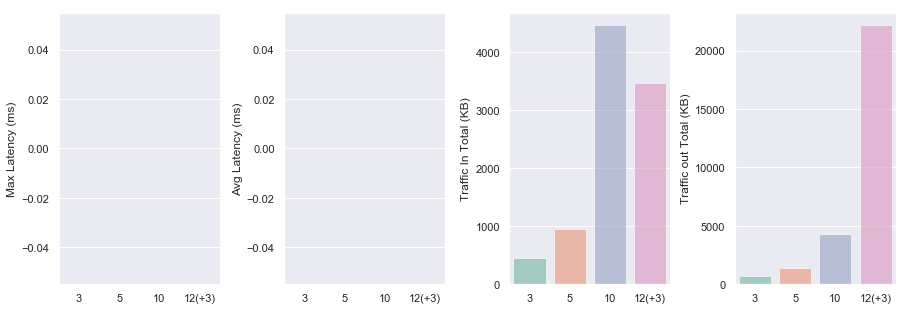

In [69]:
plot_scaling('server')

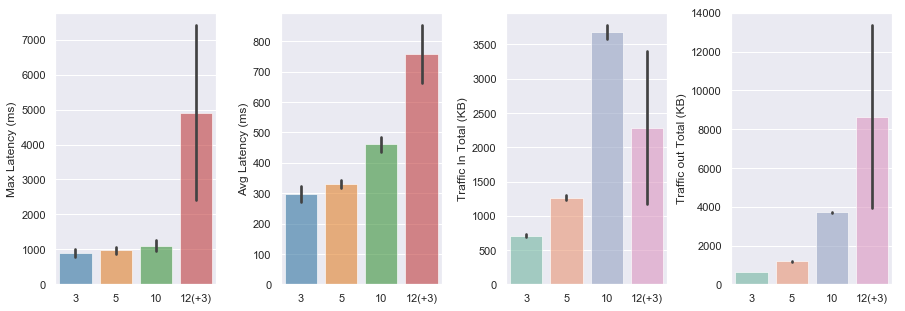

In [70]:
plot_scaling('client')